## Dimensiones

Para una capa $l$:

- $\mathbf{W}^{(l)}$ tiene dimensiones ${(d^{(l-1)}+1)\times d^{(l)}}$
- $\hat{s}^{(l)}$ tiene dimensiones $d^{(l)}\times 1$
- $\hat{x}^{(l)}$ tiene dimensiones $(d^{(l)}+1)\times 1$

Podemos entrenar la red neuronal con varios datos de entrenamiento de un solo golpe.

En este caso, las dimensiones con las que se trabajan en la capa $l$ son:

- $\mathbf{W}^{(l)}$ tiene dimensiones ${(d^{(l-1)}+1)\times d^{(l)}}$
- $\mathbf{S}^{(l)}$ tiene dimensiones $d^{(l)}\times N$
- $\mathbf{X}^{(l)}$ tiene dimensiones $(d^{(l)}+1)\times N$

donde $N$ es la cantidad de datos de entrenamiento.

## Restricciones

Esta implementación requiere que los valores de entrada de una red neuronal tengan dominio $[0,1]$

## Función de transformación

In [1]:
function logistic(S)
    1 ./ (1 .+ exp(-S))
end

logistic (generic function with 1 method)

In [2]:
function logisticDeriv(S)
    expS = exp(S)
    expS ./ (expS + 1)^2
end

logisticDeriv (generic function with 1 method)

In [3]:
function logit(X)
    -log((1 ./ X) .- 1)
end

logit (generic function with 1 method)

## Descripción de una red neuronal

In [4]:
type FFNeuralNetwork
    d::Array{Int64,1}             # dimension of each layer
    Ws::Array{Array{Float64,2},1} # weights of each layer
end

In [5]:
using Distributions

function MakeFFNN(d)
    Ws = Array{Array{Float64,2},1}()
    push!(Ws, rand(1,1))
    for (dPrev, dCurr) in zip(d, d[2:end])
        W = rand(Uniform(-sqrt(dPrev+1), sqrt(dPrev+1)),(dPrev+1, dCurr))
        push!(Ws, W)
    end
    FFNeuralNetwork(d, Ws)
end

function dimensions(NN)
    eachindex(NN.d)
end

function layers(NN)
    eachindex(NN.d)[2:end]
end

function weights(NN, layer)
    NN.Ws[layer]
end

weights (generic function with 1 method)

## FeedForward

![algorithm1.png](algorithm1.png)

In [6]:
function forwardPropagation(NN, x)
    for l in layers(NN)
        x = [1.0; x]
        s = weights(NN, l)' * x
        x = logistic(s)
    end
    return x
end

forwardPropagation (generic function with 1 method)

## BackPropagation

![algorithm2.png](algorithm2.png)

In [7]:
function backPropagation(NN::FFNeuralNetwork, x, y)
    L = length(NN.d)
    
    # 0. Run forward propagation
    xs = Array{Array{Float64, 1}, 1}(L)
    xs[1] = x

    ss = Array{Array{Float64, 1}, 1}(L)
    for l in layers(NN)
        xs[l-1] = [1.0; xs[l-1]]
        ss[l] = weights(NN, l)' * xs[l-1]
        xs[l] = logistic(ss[l])
    end
    
    # 1. Initialization
    Ds = Array{Array{Float64, 1}, 1}(L)
    Ds[L] = 2*(xs[L]-y) .* (xs[L] .* (1-xs[L]))
    
    # 2. Back propagation
    for l in layers(NN)[end-1:-1:1]
        thetaDerivS = (xs[l][2:end] .* (1-xs[l][2:end]))
        Ds[l] = thetaDerivS .* (Ws[l+1]*Ds[l+1])[2:end]
    end
    return Ds
end

backPropagation (generic function with 1 method)

## Calculando el error en muestra

![algorithm3.png](algorithm3.png)

In [8]:
function insampleError(NN::FFNeuralNetwork, X, Y)
    Ws = NN.Ws
    L = length(NN.d)
    N = size(X)[2]
    o = size(Y)[1]
    
    # Initialization
    Ein = zeros(o)
    gradEin = Array{Array{Float64,2},1}(L)
    for l in layers(NN)
        gradEin[l] = zeros(Ws[l])
    end
    
    # Data iteration
    for i in 1:N
        ys = Y[:,i]
        # Forward propagation
        xs = Array{Array{Float64, 1}, 1}(L)
        xs[1] = X[:,i]

        ss = Array{Array{Float64, 1}, 1}(L)
        for l in layers(NN)
            xs[l-1] = [1.0; xs[l-1]]
            ss[l] = weights(NN, l)' * xs[l-1]
            xs[l] = logistic(ss[l])
        end
        
        # Backpropagation
        Ds = Array{Array{Float64, 1}, 1}(L)
        Ds[L] = 2*(xs[L]-ys) .* (xs[L] .* (1-xs[L]))

        # 2. Back propagation
        for l in layers(NN)[end-1:-1:1]
            thetaDerivS = (xs[l][2:end] .* (1-xs[l][2:end]))
            Ds[l] = thetaDerivS .* (Ws[l+1]*Ds[l+1])[2:end]
        end
        
        # In sample error
        diff = (xs[L] - ys)
        Ein = Ein + (1/N) .* diff .* diff
        
        # Error gradient
        for l in layers(NN)
            gradEin[l] = gradEin[l]+(1/N).*(xs[l-1]*(Ds[l])')
        end
        
        return Ein, gradEin
    end
end

insampleError (generic function with 1 method)

## Descenso de gradiente estocástico

In [9]:
function SGD(NN::FFNeuralNetwork, X, Y, epochs, lrate)
    Ws = NN.Ws
    L = length(NN.d)
    N = size(X)[2]
    o = size(Y)[1]
    
    # Initialization
    Ein = zeros(o)
    gradEin = Array{Array{Float64,2},1}(L)
    for l in layers(NN)
        gradEin[l] = zeros(Ws[l])
    end
    
    # Weight approximation
    for e in 1:epochs
        # Data iteration
        for i in 1:N
            ys = Y[:,i]
            # Forward propagation
            xs = Array{Array{Float64, 1}, 1}(L)
            xs[1] = X[:,i]

            ss = Array{Array{Float64, 1}, 1}(L)
            for l in layers(NN)
                xs[l-1] = [1.0; xs[l-1]]
                ss[l] = weights(NN, l)' * xs[l-1]
                xs[l] = logistic(ss[l])
            end

            # Backpropagation
            Ds = Array{Array{Float64, 1}, 1}(L)
            Ds[L] = 2*(xs[L]-ys) .* (xs[L] .* (1-xs[L]))

            # 2. Back propagation
            for l in layers(NN)[end-1:-1:1]
                thetaDerivS = (xs[l][2:end] .* (1-xs[l][2:end]))
                Ds[l] = thetaDerivS .* (Ws[l+1]*Ds[l+1])[2:end]
            end

            # In sample error
            diff = (xs[L] - ys)
            Ein = Ein + (1/N) .* diff .* diff
            
            # Error gradient
            for l in layers(NN)
                gradEin[l] = gradEin[l]+(1/N).*(xs[l-1]*(Ds[l])')
                Ws[l] = Ws[l] - lrate .* gradEin[l]
            end
        end
    end
end

SGD (generic function with 1 method)

## Prediciendo la función seno

In [111]:
using Gadfly
using Colors

In [112]:
N = 50

X1 = rand(Normal(.5,.1), Int64(N*(1/5)))
X2 = rand(Uniform(0, 1) , Int64(N*(4/5)))
X = [X1;X2]
y = (sin(2pi*X)+1)/2;

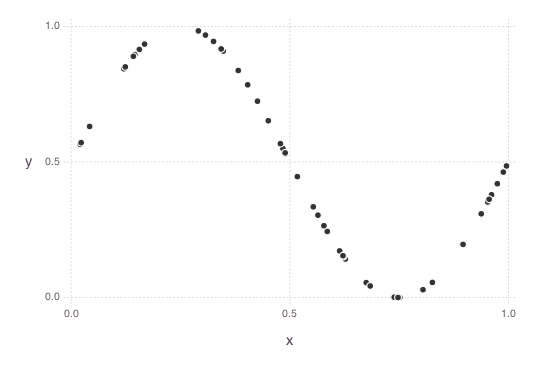

In [113]:
Gadfly.plot( x = X, y = y, 
    
    Theme(default_color = RGB(.2, .2, .2)),
    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1))

### Red neuronal sin entrenamiento

In [129]:
NN = MakeFFNN([1, 4, 2, 10, 1]);

In [130]:
ŷ = [forwardPropagation(NN, x)[1] for x in X];

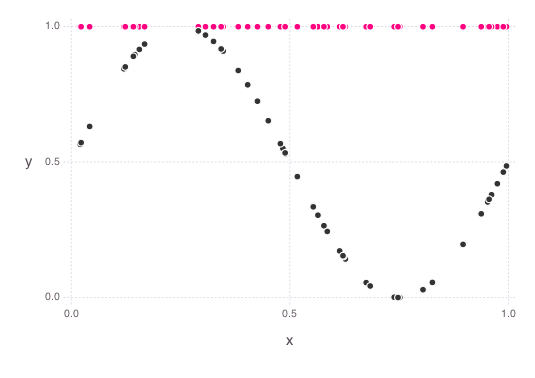

In [131]:
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGB(.2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),

    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)

### Cascareandola un poquito

In [132]:
SGD(NN, X', y', 150, .01)

In [133]:
ŷ = [forwardPropagation(NN, x)[1] for x in X];

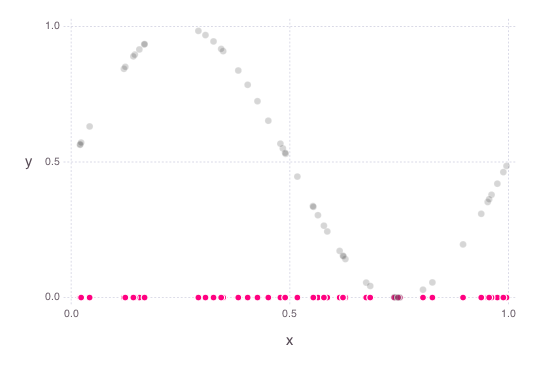

In [134]:
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGBA(.2, .2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),

    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)

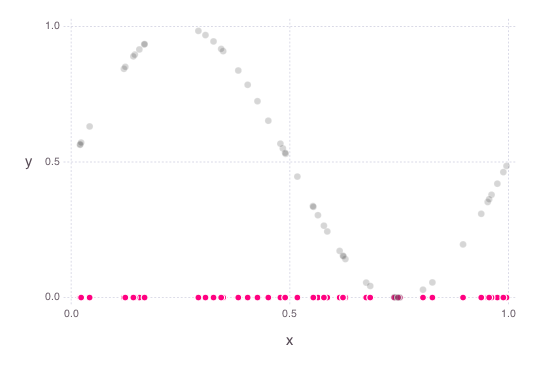

In [135]:
SGD(NN, X', y', 150, .01)
ŷ = [forwardPropagation(NN, x)[1] for x in X];
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGBA(.2, .2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),



    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)

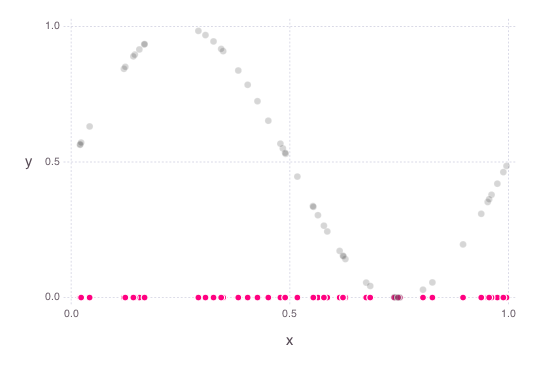

In [136]:
SGD(NN, X', y', 150, .01)
ŷ = [forwardPropagation(NN, x)[1] for x in X];
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGBA(.2, .2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),



    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)

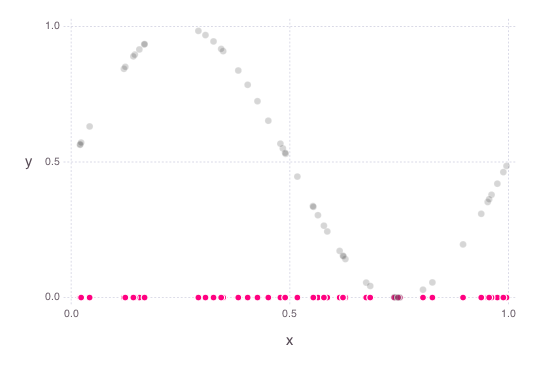

In [137]:
SGD(NN, X', y', 150, .01)
ŷ = [forwardPropagation(NN, x)[1] for x in X];
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGBA(.2, .2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),



    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)

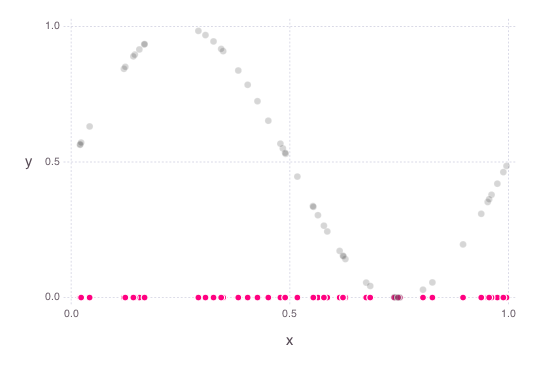

In [138]:
SGD(NN, X', y', 150, .01)
ŷ = [forwardPropagation(NN, x)[1] for x in X];
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGBA(.2, .2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),



    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)

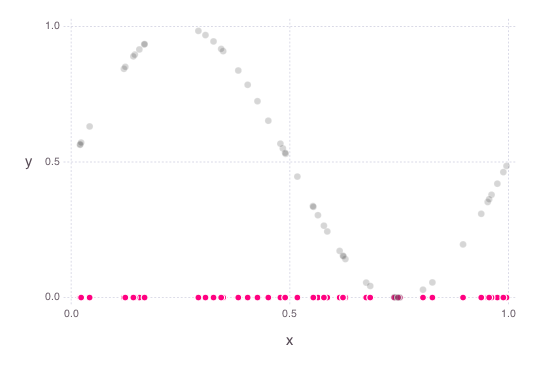

In [139]:
SGD(NN, X', y', 150, .01)
ŷ = [forwardPropagation(NN, x)[1] for x in X];
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGBA(.2, .2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),



    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)

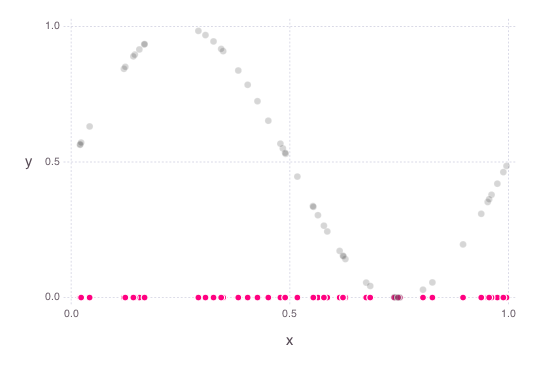

In [140]:
SGD(NN, X', y', 150, .01)
ŷ = [forwardPropagation(NN, x)[1] for x in X];
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGBA(.2, .2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),



    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)

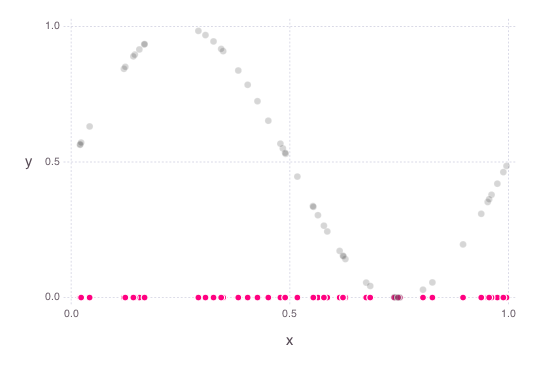

In [141]:
SGD(NN, X', y', 150, .01)
ŷ = [forwardPropagation(NN, x)[1] for x in X];
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGBA(.2, .2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),



    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)

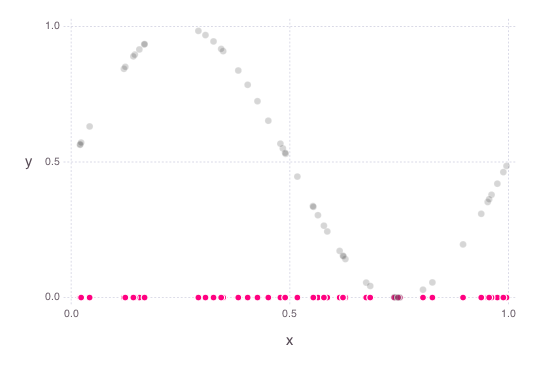

In [142]:
SGD(NN, X', y', 150, .01)
ŷ = [forwardPropagation(NN, x)[1] for x in X];
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGBA(.2, .2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),



    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)

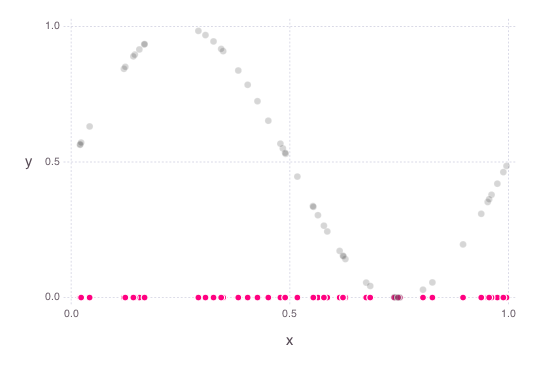

In [143]:
SGD(NN, X', y', 150, .01)
ŷ = [forwardPropagation(NN, x)[1] for x in X];
Gadfly.plot(layer(x = X, y = y, 
                Geom.point, Theme(default_color = RGBA(.2, .2, .2, .2))),
            
            layer(x = X, y = ŷ,
                Geom.point, Theme(default_color = RGB(1, 0, .5))),



    Scale.x_continuous(minvalue=0, maxvalue=1),
    Scale.y_continuous(minvalue=0, maxvalue=1)
)